# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Project Steps

1. <a href="#eda">Data Exploration</a>
2. <a href="#cleaning">Cleaning</a>


<a id="#eda"></a>

# Data Exploration

In [1]:
import pandas as pd
import seaborn as sns
#import numpy as np
import math
#import json
from sklearn.model_selection import train_test_split
%matplotlib inline

import utils

# read in the json files
offers = pd.read_json('data/portfolio.json', orient='records', lines=True)
users = pd.read_json('data/profile.json', orient='records', lines=True)
transactions = pd.read_json('data/transcript.json', orient='records', lines=True)

## offers

In [2]:
offers

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


This data set is pretty simple. There were 10 different offers:
- 4 BOGO
- 4 discounts
- informational

All offers were sent through **email**. Other channels were used for different offers.

## users

In [3]:
users.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [5]:
users.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


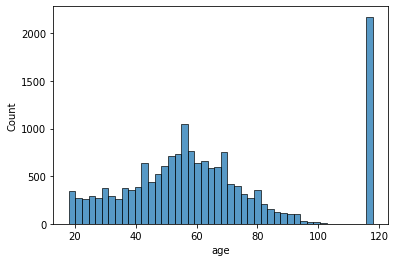

In [6]:
sns.histplot(data=users, x='age');

**users** data set has some missing values in **gender** and **income** columns. Missing values in **age** encoded as 118.

In [7]:
users['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

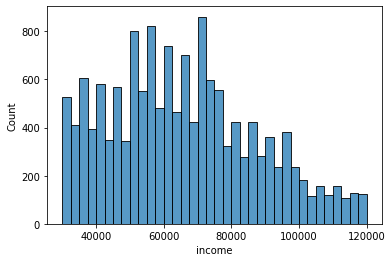

In [8]:
sns.histplot(data=users, x='income');

In [9]:
cnt_no_gender = len(users[users['gender'].isnull()])
cnt_no_income = len(users[users['income'].isnull()])
cnt_no_gender_income = len(users[users['gender'].isnull() & users['income'].isnull()])
print(f'no gender {cnt_no_gender}\nno income {cnt_no_income}\nno gender and income {cnt_no_gender_income}')

no gender 2175
no income 2175
no gender and income 2175


Users either have all data, or missing both **gender** and **income**.

## transactions

In [10]:
transactions.iloc[20000:20006,:]

,person,event,value,time
20000,158ccf2ed90541e7973106134cb1bba3,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,12
20001,4d81f9f887724401a9c7606db4afef01,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},12
20002,f2265b809d1949c1a7b63a9386bf4946,transaction,{'amount': 17.68},12
20003,f2265b809d1949c1a7b63a9386bf4946,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,12
20004,19afb26b9a10447a8a2f86fa9f65c75d,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},12
20005,94d82c681c994c319b4f3b648e351e56,transaction,{'amount': 6.33},12


In [11]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


There are no missing data.

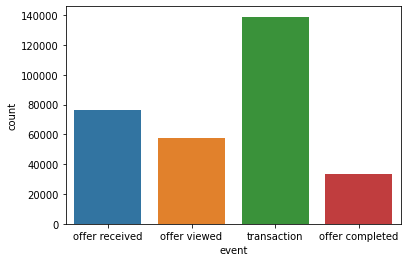

In [12]:
sns.countplot(x='event', data=transactions);

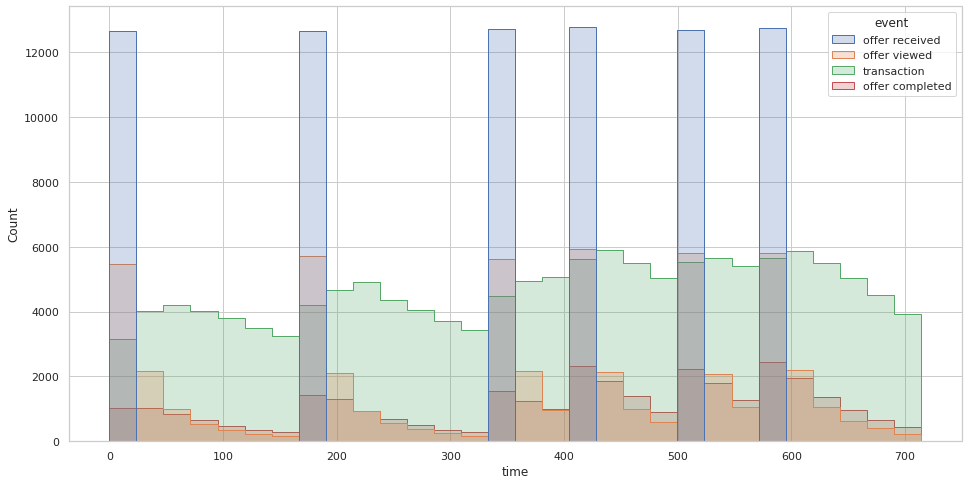

In [13]:
time_in_days = math.ceil(transactions['time'].max()/24)
sns.set(style="whitegrid", rc={'figure.figsize':(16,8)})
sns.histplot(x='time', data=transactions, hue='event', element="step", bins=time_in_days);
sns.reset_defaults()


## Combine datasets

<a id="#cleaning"></a>

## Cleaning

### offers

In [14]:
channels_list = set([val for sublist in offers['channels'] for val in sublist])
channels_list

{'email', 'mobile', 'social', 'web'}

In [15]:
for channel in channels_list:
    offers[channel] = offers['channels'].apply(lambda x: int(channel in x))
offers = offers.drop(columns='channels')
offers

,reward,difficulty,duration,offer_type,id,email,social,web,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,1


In [16]:
offers = pd.concat([offers, pd.get_dummies(offers['offer_type'])], axis=1).drop(columns=['offer_type'])
offers

,reward,difficulty,duration,id,email,social,web,mobile,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,0,1,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,0,1,1,0,1,0


In [17]:
offers['id'], offers['orig_id'] = offers['id'].factorize()
offers['id'] = offers['id'] + 1
offers

,reward,difficulty,duration,id,email,social,web,mobile,bogo,discount,informational,orig_id
0,10,10,7,1,1,1,0,1,1,0,0,ae264e3637204a6fb9bb56bc8210ddfd
1,10,10,5,2,1,1,1,1,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,0,4,3,1,0,1,1,0,0,1,3f207df678b143eea3cee63160fa8bed
3,5,5,7,4,1,0,1,1,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,20,10,5,1,0,1,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,7,7,6,1,1,1,1,0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,10,10,7,1,1,1,1,0,1,0,fafdcd668e3743c1bb461111dcafc2a4
7,0,0,3,8,1,1,0,1,0,0,1,5a8bc65990b245e5a138643cd4eb9837
8,5,5,5,9,1,1,1,1,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d
9,2,10,7,10,1,0,1,1,0,1,0,2906b810c7d4411798c6938adc9daaa5


In [18]:
offers.to_csv('data/offers.csv', index=False)

### users

In [19]:
users['gender'] = users['gender'].fillna('no_gender')
users = pd.concat([users, pd.get_dummies(users['gender'])], axis=1).drop(columns='gender')
users

,age,id,became_member_on,income,F,M,O,no_gender
0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0,0,0,1
1,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0,0
2,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,0,0,0,1
3,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0,0
4,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...
16995,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,1,0,0,0
16996,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,0,1,0,0
16997,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,0,1,0,0
16998,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,1,0,0,0


In [20]:
users['id'], users['orig_id'] = users['id'].factorize()
users['id'] = users['id'] + 1
users

,age,id,became_member_on,income,F,M,O,no_gender,orig_id
0,118,1,20170212,NaN,0,0,0,1,68be06ca386d4c31939f3a4f0e3dd783
1,55,2,20170715,112000.0,1,0,0,0,0610b486422d4921ae7d2bf64640c50b
2,118,3,20180712,NaN,0,0,0,1,38fe809add3b4fcf9315a9694bb96ff5
3,75,4,20170509,100000.0,1,0,0,0,78afa995795e4d85b5d9ceeca43f5fef
4,118,5,20170804,NaN,0,0,0,1,a03223e636434f42ac4c3df47e8bac43
...,...,...,...,...,...,...,...,...,...
16995,45,16996,20180604,54000.0,1,0,0,0,6d5f3a774f3d4714ab0c092238f3a1d7
16996,61,16997,20180713,72000.0,0,1,0,0,2cb4f97358b841b9a9773a7aa05a9d77
16997,49,16998,20170126,73000.0,0,1,0,0,01d26f638c274aa0b965d24cefe3183f
16998,83,16999,20160307,50000.0,1,0,0,0,9dc1421481194dcd9400aec7c9ae6366


In [21]:
users['age'] = users['age'].apply(lambda x: 0 if x==118 else x)
users

,age,id,became_member_on,income,F,M,O,no_gender,orig_id
0,0,1,20170212,NaN,0,0,0,1,68be06ca386d4c31939f3a4f0e3dd783
1,55,2,20170715,112000.0,1,0,0,0,0610b486422d4921ae7d2bf64640c50b
2,0,3,20180712,NaN,0,0,0,1,38fe809add3b4fcf9315a9694bb96ff5
3,75,4,20170509,100000.0,1,0,0,0,78afa995795e4d85b5d9ceeca43f5fef
4,0,5,20170804,NaN,0,0,0,1,a03223e636434f42ac4c3df47e8bac43
...,...,...,...,...,...,...,...,...,...
16995,45,16996,20180604,54000.0,1,0,0,0,6d5f3a774f3d4714ab0c092238f3a1d7
16996,61,16997,20180713,72000.0,0,1,0,0,2cb4f97358b841b9a9773a7aa05a9d77
16997,49,16998,20170126,73000.0,0,1,0,0,01d26f638c274aa0b965d24cefe3183f
16998,83,16999,20160307,50000.0,1,0,0,0,9dc1421481194dcd9400aec7c9ae6366


In [22]:
users.to_csv('data/users.csv', index=False)

### transactions

In [23]:
values_list = set([val for dict_vals in transactions['value'] for val in dict(dict_vals).keys()])
values_list

{'amount', 'offer id', 'offer_id', 'reward'}

There are 2 different spellings for **offer id**. We will need to combine them.

In [24]:
for val in values_list:
    transactions[val] = transactions['value'].apply(lambda x: val in dict(x).keys())
transactions

,person,event,value,time,offer_id,offer id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,False,True,False,False
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,False,True,False,False
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,False,True,False,False
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,False,True,False,False
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,False,True,False,False
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,False,False,True,False
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,False,False,True,False
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,False,False,True,False
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,False,False,True,False


In [25]:
transactions[transactions['offer_id'] & transactions['offer id']]

,person,event,value,time,offer_id,offer id,amount,reward


Just made sure that there are no records with both **offer_id** and  **offer id**.

In [26]:
new_value_columns = transactions.apply(lambda x: [
            x['value'].get('offer_id',0) if x['value'].get('offer_id',0) else x['value'].get('offer id',0),
            x['value'].get('amount',0),
            x['value'].get('reward',0)
        ], axis=1, result_type='expand')
new_transactions = pd.concat([transactions, new_value_columns], axis=1)
new_transactions.iloc[12735:12745,:]

,person,event,value,time,offer_id,offer id,amount,reward,0,1,2
12735,662f3247f37c4ae7a2abb8f6e266a633,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,False,True,False,False,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
12736,a453d70e85fd493f9584570a3dae58a8,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,False,True,False,False,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
12737,c3b7848d96014017ad1272188e170554,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,False,True,False,False,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0.0
12738,7ca349e55ff544c7a13addfdea2e2c06,transaction,{'amount': 1.02},0,False,False,True,False,0.0,1.02,0.0
12739,6ec36134940f43aeb43cffa2011a6d26,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,False,True,False,False,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,0.0
12740,461e13a14a074077b3ebd7ad0174e02b,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,False,True,False,False,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0
12741,490b282bfc3945df8ac3bbe54dd400fe,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,False,True,False,False,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
12742,d72d201be5794279aa716d8ad82b8d90,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,False,True,False,False,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
12743,d72d201be5794279aa716d8ad82b8d90,transaction,{'amount': 13.57},0,False,False,True,False,0.0,13.57,0.0
12744,d72d201be5794279aa716d8ad82b8d90,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,0,True,False,False,True,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0


In [27]:
new_transactions = new_transactions.drop(columns=['value','amount','offer_id','reward','offer id'])
new_transactions = new_transactions.rename(columns={0:'offer',1:'amount',2:'reward_earned'})
print(new_transactions.shape)
new_transactions.iloc[12735:12745,:]

(306534, 6)


,person,event,time,offer,amount,reward_earned
12735,662f3247f37c4ae7a2abb8f6e266a633,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
12736,a453d70e85fd493f9584570a3dae58a8,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
12737,c3b7848d96014017ad1272188e170554,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0.0
12738,7ca349e55ff544c7a13addfdea2e2c06,transaction,0,0.0,1.02,0.0
12739,6ec36134940f43aeb43cffa2011a6d26,offer viewed,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,0.0
12740,461e13a14a074077b3ebd7ad0174e02b,offer viewed,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0
12741,490b282bfc3945df8ac3bbe54dd400fe,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
12742,d72d201be5794279aa716d8ad82b8d90,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
12743,d72d201be5794279aa716d8ad82b8d90,transaction,0,0.0,13.57,0.0
12744,d72d201be5794279aa716d8ad82b8d90,offer completed,0,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0


In [28]:
new_transactions = new_transactions.merge(users[['id','orig_id']], how='left', left_on='person', right_on='orig_id')
new_transactions = new_transactions.drop(columns=['orig_id']).rename(columns={'id':'person_id'})
new_transactions

,person,event,time,offer,amount,reward_earned,person_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0.0,4
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0.0,5
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.00,0.0,6
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0,7
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0.0,8
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,0.0,1.59,0.0,16960
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,0.0,9.53,0.0,16965
306531,a00058cf10334a308c68e7631c529907,transaction,714,0.0,3.61,0.0,16980
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,0.0,3.53,0.0,16988


In [29]:
new_transactions = new_transactions.merge(offers[['id','orig_id']], how='left', left_on='offer', right_on='orig_id')
new_transactions

,person,event,time,offer,amount,reward_earned,person_id,id,orig_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0.0,4,4.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0.0,5,5.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.00,0.0,6,10.0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0,7,7.0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0.0,8,2.0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,0.0,1.59,0.0,16960,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,0.0,9.53,0.0,16965,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,0.0,3.61,0.0,16980,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,0.0,3.53,0.0,16988,NaN,NaN


In [30]:
new_transactions = new_transactions.drop(columns=['orig_id']).rename(columns={'id':'offer_id'})
new_transactions['offer_id'] = new_transactions['offer_id'].fillna(0).astype(int)
new_transactions

,person,event,time,offer,amount,reward_earned,person_id,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0.0,4,4
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0.0,5,5
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.00,0.0,6,10
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0,7,7
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0.0,8,2
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,0.0,1.59,0.0,16960,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,0.0,9.53,0.0,16965,0
306531,a00058cf10334a308c68e7631c529907,transaction,714,0.0,3.61,0.0,16980,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,0.0,3.53,0.0,16988,0


In [31]:
new_transactions.to_csv('data/transactions.csv', index=False)

##### Creating one record for each user-offer

In [32]:
new_transactions['time'] = new_transactions['time'] + 1
new_transactions = new_transactions.drop(columns=['person','offer']).rename(columns={'offer_id':'offer','person_id':'person'})
new_transactions

,event,time,amount,reward_earned,person,offer
0,offer received,1,0.00,0.0,4,4
1,offer received,1,0.00,0.0,5,5
2,offer received,1,0.00,0.0,6,10
3,offer received,1,0.00,0.0,7,7
4,offer received,1,0.00,0.0,8,2
...,...,...,...,...,...,...
306529,transaction,715,1.59,0.0,16960,0
306530,transaction,715,9.53,0.0,16965,0
306531,transaction,715,3.61,0.0,16980,0
306532,transaction,715,3.53,0.0,16988,0


In [33]:
event_received_df = new_transactions[new_transactions['event']=='offer received']
event_viewed_df = new_transactions[new_transactions['event']=='offer viewed']
event_transaction_df = new_transactions[new_transactions['event']=='transaction']
event_completed_df = new_transactions[new_transactions['event']=='offer completed']
print(event_received_df.shape)
print(event_viewed_df.shape)
print(event_transaction_df.shape)
print(event_completed_df.shape)
print(f'Total: {event_received_df.shape[0]+event_viewed_df.shape[0]+event_transaction_df.shape[0]+event_completed_df.shape[0]}')

(76277, 6)
(57725, 6)
(138953, 6)
(33579, 6)
Total: 306534


In [34]:
event_received_df[(event_received_df['amount']!=0) | (event_received_df['reward_earned']!=0)]

,event,time,amount,reward_earned,person,offer


In [35]:
event_received_df = event_received_df.rename(columns={'time':'offer_received'}).drop(columns=['event','amount','reward_earned'])
event_received_df

,offer_received,person,offer
0,1,4,4
1,1,5,5
2,1,6,10
3,1,7,7
4,1,8,2
...,...,...,...
257882,577,16956,1
257883,577,16994,10
257884,577,16996,6
257885,577,16999,1


In [36]:
event_viewed_df[(event_viewed_df['amount']!=0) | (event_viewed_df['reward_earned']!=0)]

,event,time,amount,reward_earned,person,offer


In [37]:
event_viewed_df = event_viewed_df.rename(columns={'time':'offer_viewed'}).drop(columns=['event','amount','reward_earned'])
event_viewed_df

,offer_viewed,person,offer
12650,1,9,9
12651,1,32,8
12652,1,36,2
12653,1,42,1
12655,1,49,8
...,...,...,...
306441,715,15747,8
306450,715,15920,3
306483,715,16425,8
306490,715,16569,3


In [38]:
event_received_df[event_received_df.duplicated(subset=['person','offer'], keep=False)].sort_values(by=['person','offer'])

,offer_received,person,offer
150596,409,1,7
245122,577,1,7
1,1,5,5
201573,505,5,5
245125,577,5,5
...,...,...,...
214271,505,16992,1
12646,1,16994,10
257883,577,16994,10
123538,337,17000,3


Users could receive the same offer a few times, sometimes, when previous didn't expire yet.

##### Merging received and viewed offers

In [39]:
event_received_viewed_df = pd.merge_asof(event_viewed_df, event_received_df, by=['person','offer'], left_on=['offer_viewed'], right_on=['offer_received'])
event_received_viewed_df['offer_viewed'] = event_received_viewed_df['offer_viewed'].astype(int)
event_received_viewed_df

,offer_viewed,person,offer,offer_received
0,1,9,9,1
1,1,32,8,1
2,1,36,2,1
3,1,42,1,1
4,1,49,8,1
...,...,...,...,...
57720,715,15747,8,577
57721,715,15920,3,577
57722,715,16425,8,577
57723,715,16569,3,577


In [40]:
event_received_viewed_df = event_received_df.merge(event_received_viewed_df, how='left', on=['person','offer','offer_received'])
event_received_viewed_df['offer_viewed'] = event_received_viewed_df['offer_viewed'].fillna(0).astype(int)
event_received_viewed_df

,offer_received,person,offer,offer_viewed
0,1,4,4,7
1,1,5,5,7
2,1,6,10,19
3,1,7,7,13
4,1,8,2,85
...,...,...,...,...
76272,577,16956,1,673
76273,577,16994,10,0
76274,577,16996,6,589
76275,577,16999,1,625


In [41]:
offer_duration = dict(zip(offers['id'], offers['duration']*24))
offer_duration

{1: 168, 2: 120, 3: 96, 4: 168, 5: 240, 6: 168, 7: 240, 8: 72, 9: 120, 10: 168}

In [42]:
event_received_viewed_df['offer_expire'] = event_received_viewed_df.apply(lambda x: x['offer_received']+offer_duration[x['offer']], axis=1)
event_received_viewed_df

,offer_received,person,offer,offer_viewed,offer_expire
0,1,4,4,7,169
1,1,5,5,7,241
2,1,6,10,19,169
3,1,7,7,13,241
4,1,8,2,85,121
...,...,...,...,...,...
76272,577,16956,1,673,745
76273,577,16994,10,0,745
76274,577,16996,6,589,745
76275,577,16999,1,625,745


##### Merge transactions with completed offers.

In [43]:
event_completed_df

,event,time,amount,reward_earned,person,offer
12658,offer completed,1,0.0,2.0,56,10
12672,offer completed,1,0.0,2.0,152,7
12679,offer completed,1,0.0,5.0,175,4
12692,offer completed,1,0.0,10.0,300,1
12697,offer completed,1,0.0,10.0,317,2
...,...,...,...,...,...,...
306475,offer completed,715,0.0,3.0,16339,6
306497,offer completed,715,0.0,3.0,16665,6
306506,offer completed,715,0.0,2.0,16765,7
306509,offer completed,715,0.0,2.0,16768,7


In [44]:
event_completed_df[event_completed_df['amount']!=0]

,event,time,amount,reward_earned,person,offer


In [45]:
event_completed_df = event_completed_df.rename(columns={'time':'offer_completed'}).drop(columns=['event','amount'])
event_completed_df

,offer_completed,reward_earned,person,offer
12658,1,2.0,56,10
12672,1,2.0,152,7
12679,1,5.0,175,4
12692,1,10.0,300,1
12697,1,10.0,317,2
...,...,...,...,...
306475,715,3.0,16339,6
306497,715,3.0,16665,6
306506,715,2.0,16765,7
306509,715,2.0,16768,7


In [46]:
event_transaction_df

,event,time,amount,reward_earned,person,offer
12654,transaction,1,0.83,0.0,42,0
12657,transaction,1,34.56,0.0,56,0
12659,transaction,1,13.23,0.0,64,0
12670,transaction,1,19.51,0.0,135,0
12671,transaction,1,18.97,0.0,152,0
...,...,...,...,...,...,...
306529,transaction,715,1.59,0.0,16960,0
306530,transaction,715,9.53,0.0,16965,0
306531,transaction,715,3.61,0.0,16980,0
306532,transaction,715,3.53,0.0,16988,0


In [47]:
event_transaction_df[(event_transaction_df['offer']!=0) | (event_transaction_df['reward_earned']!=0)]

,event,time,amount,reward_earned,person,offer


**offer** and **reward_earned**  are always equal to 0, and **offer** is always equal to 'transaction', so we can drop these columns.

In [48]:
event_transaction_df = event_transaction_df.rename(columns={'time':'transaction'}).drop(columns=['event','offer','reward_earned'])
event_transaction_df

,transaction,amount,person
12654,1,0.83,42
12657,1,34.56,56
12659,1,13.23,64
12670,1,19.51,135
12671,1,18.97,152
...,...,...,...
306529,715,1.59,16960
306530,715,9.53,16965
306531,715,3.61,16980
306532,715,3.53,16988


In [49]:
event_transaction_df.sort_values(by=['person','transaction']).head(10)

,transaction,amount,person
135224,361,0.35,1
167626,415,0.74,1
182544,445,1.89,1
218392,511,5.04,1
230411,535,0.38,1
237364,553,2.12,1
274519,607,4.61,1
283959,631,0.06,1
301915,697,5.21,1
20282,19,21.51,2


In [50]:
event_completed_df.sort_values(by=['person','offer_completed']).head(10)

,offer_completed,reward_earned,person,offer
237365,553,2.0,1,7
237366,553,3.0,1,6
227843,529,5.0,2,4
47583,133,5.0,4,4
218394,511,10.0,4,1
218395,511,5.0,4,9
225061,523,5.0,6,4
225062,523,2.0,6,7
32626,61,5.0,9,9
200085,499,2.0,9,10


In [51]:
event_transaction_completed_df = pd.merge_asof(event_completed_df, event_transaction_df, by=['person'], left_on=['offer_completed'], right_on=['transaction'])
event_transaction_completed_df.sort_values(by=['person','offer_completed']).head(10)

,offer_completed,reward_earned,person,offer,transaction,amount
24490,553,2.0,1,7,553,2.12
24491,553,3.0,1,6,553,2.12
22700,529,5.0,2,4,529,23.22
4210,133,5.0,4,4,133,19.89
21070,511,10.0,4,1,511,21.72
21071,511,5.0,4,9,511,21.72
22192,523,5.0,6,4,523,18.42
22193,523,2.0,6,7,523,18.42
2497,61,5.0,9,9,61,9.54
20267,499,2.0,9,10,499,15.63


In [52]:
event_transaction_completed_df[event_transaction_completed_df['offer_completed']!=event_transaction_completed_df['transaction']]

,offer_completed,reward_earned,person,offer,transaction,amount


In [53]:
event_transaction_completed_df = event_transaction_df.merge(event_transaction_completed_df, how='left', on=['person','transaction','amount'])
event_transaction_completed_df[['offer','offer_completed']] = event_transaction_completed_df[['offer','offer_completed']].fillna(0).astype(int)
event_transaction_completed_df['reward_earned'] = event_transaction_completed_df['reward_earned'].fillna(0)
event_transaction_completed_df

,transaction,amount,person,offer_completed,reward_earned,offer
0,1,0.83,42,0,0.0,0
1,1,34.56,56,1,2.0,10
2,1,13.23,64,0,0.0,0
3,1,19.51,135,0,0.0,0
4,1,18.97,152,1,2.0,7
...,...,...,...,...,...,...
141910,715,1.59,16960,0,0.0,0
141911,715,9.53,16965,0,0.0,0
141912,715,3.61,16980,0,0.0,0
141913,715,3.53,16988,0,0.0,0


More records, because of duplicates in completed offers (sometimes one transaction creates 2 or more completing records):

| person | transaction | amount |offer_completed | offer |reward_earned |
| --- | - | - | - | - | - |
| 0011e0d4e6b944f998e987f904e8c1e5 | 253 | 11.93 | 253.0 | 2298d6c36e964ae4a3e7e9706d1fb8c2 | 3.0 |
| 0011e0d4e6b944f998e987f904e8c1e5 | 577 | 22.05 | 577.0 | 0b1e1539f2cc45b7b9fa7c272da2e1d7 | 5.0 |
| 0011e0d4e6b944f998e987f904e8c1e5 | 577 | 22.05 | 577.0 | 9b98b8c7a33c4b65b9aebfe6a799e6d9 | 5.0 |
| 0011e0d4e6b944f998e987f904e8c1e5 | 643 | 23.03 | NaN | NaN | NaN |


##### Merge received/reviewed with transactions/completed

In [54]:
event_received_viewed_df

,offer_received,person,offer,offer_viewed,offer_expire
0,1,4,4,7,169
1,1,5,5,7,241
2,1,6,10,19,169
3,1,7,7,13,241
4,1,8,2,85,121
...,...,...,...,...,...
76272,577,16956,1,673,745
76273,577,16994,10,0,745
76274,577,16996,6,589,745
76275,577,16999,1,625,745


In [55]:
event_transaction_completed_df

,transaction,amount,person,offer_completed,reward_earned,offer
0,1,0.83,42,0,0.0,0
1,1,34.56,56,1,2.0,10
2,1,13.23,64,0,0.0,0
3,1,19.51,135,0,0.0,0
4,1,18.97,152,1,2.0,7
...,...,...,...,...,...,...
141910,715,1.59,16960,0,0.0,0
141911,715,9.53,16965,0,0.0,0
141912,715,3.61,16980,0,0.0,0
141913,715,3.53,16988,0,0.0,0


In [56]:
no_offer_transactions = event_transaction_completed_df[event_transaction_completed_df['offer']==0].sort_values(by=['person','transaction','amount']).reset_index(drop=True)
no_offer_transactions

,transaction,amount,person,offer_completed,reward_earned,offer
0,361,0.35,1,0,0.0,0
1,415,0.74,1,0,0.0,0
2,445,1.89,1,0,0.0,0
3,511,5.04,1,0,0.0,0
4,535,0.38,1,0,0.0,0
...,...,...,...,...,...,...
108331,685,11.11,16999,0,0.0,0
108332,85,25.19,17000,0,0.0,0
108333,97,21.53,17000,0,0.0,0
108334,487,19.47,17000,0,0.0,0


Some of them got an informational offer. They are not marked as completed. We need to find them.

In [57]:
info_offers = list(offers[offers['informational']==1]['id'])
info_received_viewed = event_received_viewed_df[event_received_viewed_df['offer'].isin(info_offers)]
info_received_viewed

,offer_received,person,offer,offer_viewed,offer_expire
7,1,13,3,0,97
13,1,23,3,19,97
31,1,49,8,1,73
44,1,67,8,7,73
53,1,83,8,25,73
...,...,...,...,...,...
76250,577,16967,3,0,673
76268,577,16990,3,613,673
76270,577,12963,8,607,649
76271,577,14218,8,577,649


In [58]:
not_info_received_viewed = event_received_viewed_df.drop(info_received_viewed.index)
not_info_received_viewed

,offer_received,person,offer,offer_viewed,offer_expire
0,1,4,4,7,169
1,1,5,5,7,241
2,1,6,10,19,169
3,1,7,7,13,241
4,1,8,2,85,121
...,...,...,...,...,...
76269,577,6830,5,625,817
76272,577,16956,1,673,745
76273,577,16994,10,0,745
76274,577,16996,6,589,745


In [59]:
info_received_not_viewed = info_received_viewed[info_received_viewed['offer_viewed']==0]
info_received_not_viewed

,offer_received,person,offer,offer_viewed,offer_expire
7,1,13,3,0,97
56,1,87,3,0,97
76,1,109,3,0,97
116,1,163,3,0,97
127,1,178,3,0,97
...,...,...,...,...,...
76242,577,16952,8,0,649
76247,577,16823,3,0,673
76248,577,7534,3,0,673
76250,577,16967,3,0,673


If informational offer wasn't viewed, than customer wasn't influenced by it. We can drop these offers. With other types of offers we will deal later (after merging with transactions).

In [60]:
info_received_viewed = info_received_viewed.drop(info_received_not_viewed.index)
info_received_viewed

,offer_received,person,offer,offer_viewed,offer_expire
13,1,23,3,19,97
31,1,49,8,1,73
44,1,67,8,7,73
53,1,83,8,25,73
55,1,86,8,97,73
...,...,...,...,...,...
76235,577,8834,8,661,649
76239,577,16948,8,631,649
76268,577,16990,3,613,673
76270,577,12963,8,607,649


info_received_viewed

| person | offer_received | offer | offer_viewed | offer_expire |
| - | - | - | - | - |
| 5edbee2c32e64698a6d6d4ba9012b829 | 505 | 5a8bc65990b245e5a138643cd4eb9837 | 547 | 577 |
| 5edbee2c32e64698a6d6d4ba9012b829 | 577 | 5a8bc65990b245e5a138643cd4eb9837 | 577 | 649 |

no_offer_transactions

| person | transaction | amount | offer_completed | offer | reward_earned |
| - | - | - | - | - | - |
| 5edbee2c32e64698a6d6d4ba9012b829 | 307 | 1.30 | 0 | 0 | 0.0 |
| 5edbee2c32e64698a6d6d4ba9012b829 | 397 | 1.07 | 0 | 0 | 0.0 |
| 5edbee2c32e64698a6d6d4ba9012b829 | 577 | 1.50 | 0 | 0 | 0.0 |
| 5edbee2c32e64698a6d6d4ba9012b829 | 649 | 4.58 | 0 | 0 | 0.0 |

expected:

| person | offer_received | offer | offer_viewed | offer_expire | transaction | amount | offer_completed | reward_earned |
| - | - | - | - | - | - | - | - | - |
| 5edbee2c32e64698a6d6d4ba9012b829 | 505 | 5a8bc65990b245e5a138643cd4eb9837 | 547 | 577 | 577 | 1.50 | 577 | 0 |
| 5edbee2c32e64698a6d6d4ba9012b829 | 577 | 5a8bc65990b245e5a138643cd4eb9837 | 577 | 649 | 649 | 4.58 | 0 | 0 |

wrong:

| person | offer_received | offer | offer_viewed | offer_expire | transaction | amount | offer_completed | reward_earned |
| - | - | - | - | - | - | - | - | - |
| 5edbee2c32e64698a6d6d4ba9012b829 | 505 | 5a8bc65990b245e5a138643cd4eb9837 | 547 | 577 | 0 | 0.0 | 0 | 0 |
| 5edbee2c32e64698a6d6d4ba9012b829 | 577 | 5a8bc65990b245e5a138643cd4eb9837 | 577 | 649 | 577 | 1.50 | 577 | 0 |


In [61]:
combined_info = pd.merge_asof(info_received_viewed,no_offer_transactions.sort_values(by='transaction'),by=['person'],left_on='offer_received',right_on='transaction',direction='forward',suffixes=('','_y'))
combined_info = combined_info.drop(columns=['offer_y'])
combined_info

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
0,1,23,3,19,97,19.0,13.25,0.0,0.0
1,1,49,8,1,73,7.0,2.63,0.0,0.0
2,1,67,8,7,73,25.0,13.69,0.0,0.0
3,1,83,8,25,73,25.0,0.70,0.0,0.0
4,1,86,8,97,73,547.0,33.17,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10826,577,8834,8,661,649,649.0,19.21,0.0,0.0
10827,577,16948,8,631,649,649.0,17.45,0.0,0.0
10828,577,16990,3,613,673,589.0,0.71,0.0,0.0
10829,577,12963,8,607,649,715.0,26.02,0.0,0.0


Drop records, where transaction was before viewing or after expiration: not influenced by offer.

In [62]:
to_drop = combined_info[(combined_info['transaction']<combined_info['offer_viewed']) | (combined_info['transaction']>combined_info['offer_expire'])]
to_drop

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
4,1,86,8,97,73,547.0,33.17,0.0,0.0
5,1,121,8,1,73,181.0,12.30,0.0,0.0
6,1,125,3,13,97,7.0,7.32,0.0,0.0
7,1,127,8,25,73,13.0,3.75,0.0,0.0
8,1,740,8,7,73,505.0,6.66,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10820,577,16065,8,673,649,595.0,594.23,0.0,0.0
10822,577,1848,3,655,673,679.0,22.17,0.0,0.0
10826,577,8834,8,661,649,649.0,19.21,0.0,0.0
10828,577,16990,3,613,673,589.0,0.71,0.0,0.0


In [63]:
combined_info = combined_info.drop(to_drop.index)
combined_info

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
0,1,23,3,19,97,19.0,13.25,0.0,0.0
1,1,49,8,1,73,7.0,2.63,0.0,0.0
2,1,67,8,7,73,25.0,13.69,0.0,0.0
3,1,83,8,25,73,25.0,0.70,0.0,0.0
9,1,136,3,7,97,7.0,24.25,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10823,577,16887,8,583,649,601.0,11.39,0.0,0.0
10824,577,16933,8,577,649,583.0,21.65,0.0,0.0
10825,577,16937,3,613,673,613.0,32.71,0.0,0.0
10827,577,16948,8,631,649,649.0,17.45,0.0,0.0


In [64]:
# mark them as completed
combined_info['offer_completed'] = combined_info['transaction']
combined_info

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
0,1,23,3,19,97,19.0,13.25,19.0,0.0
1,1,49,8,1,73,7.0,2.63,7.0,0.0
2,1,67,8,7,73,25.0,13.69,25.0,0.0
3,1,83,8,25,73,25.0,0.70,25.0,0.0
9,1,136,3,7,97,7.0,24.25,7.0,0.0
...,...,...,...,...,...,...,...,...,...
10823,577,16887,8,583,649,601.0,11.39,601.0,0.0
10824,577,16933,8,577,649,583.0,21.65,583.0,0.0
10825,577,16937,3,613,673,613.0,32.71,613.0,0.0
10827,577,16948,8,631,649,649.0,17.45,649.0,0.0


In [65]:
combined_info = combined_info.sort_values(by=['person','offer','offer_received'])
combined_info[combined_info.duplicated(subset=['person','offer','transaction'],keep=False) & (combined_info['transaction'].notna())]

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
4463,337,5840,3,337,433,433.0,15.72,433.0,0.0
6158,409,5840,3,433,505,433.0,15.72,433.0,0.0
7881,505,6510,8,547,577,577.0,1.50,577.0,0.0
9674,577,6510,8,577,649,577.0,1.50,577.0,0.0
8037,505,8320,8,559,577,577.0,40.01,577.0,0.0
9883,577,8320,8,577,649,577.0,40.01,577.0,0.0
7581,505,8914,3,505,601,583.0,20.59,583.0,0.0
9418,577,8914,3,577,673,583.0,20.59,583.0,0.0
6569,409,9943,3,499,505,505.0,11.48,505.0,0.0
8179,505,9943,3,505,601,505.0,11.48,505.0,0.0


In [66]:
combined_info.loc[combined_info.duplicated(subset=['person','offer','transaction'],keep='first') & (combined_info['transaction'].notna()),['transaction','amount','offer_completed']]=0
combined_info[combined_info.duplicated(subset=['person','offer','transaction'],keep=False) & (combined_info['transaction'].notna())].sort_values(by=['person','offer','offer_received'])


,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned


In [67]:
combined_info[combined_info['person']==8320]

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
8037,505,8320,8,559,577,577.0,40.01,577.0,0.0
9883,577,8320,8,577,649,0.0,0.00,0.0,0.0


In [68]:
combined_info[combined_info['transaction']==0]

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
6158,409,5840,3,433,505,0.0,0.0,0.0,0.0
9674,577,6510,8,577,649,0.0,0.0,0.0,0.0
9883,577,8320,8,577,649,0.0,0.0,0.0,0.0
9418,577,8914,3,577,673,0.0,0.0,0.0,0.0
8179,505,9943,3,505,601,0.0,0.0,0.0,0.0


In [69]:
no_offer_transactions[no_offer_transactions['person']==6510]

,transaction,amount,person,offer_completed,reward_earned,offer
41402,307,1.30,6510,0,0.0,0
41403,397,1.07,6510,0,0.0,0
41404,577,1.50,6510,0,0.0,0
41405,649,4.58,6510,0,0.0,0


In [70]:
info_received_viewed[info_received_viewed['person']==6510]

,offer_received,person,offer,offer_viewed,offer_expire
55538,505,6510,8,547,577
68272,577,6510,8,577,649


In [71]:
combined_info[combined_info['person']==6510]

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
7881,505,6510,8,547,577,577.0,1.5,577.0,0.0
9674,577,6510,8,577,649,0.0,0.0,0.0,0.0


In [72]:
combined_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6211 entries, 1934 to 6429
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   offer_received   6211 non-null   int64  
 1   person           6211 non-null   int64  
 2   offer            6211 non-null   int64  
 3   offer_viewed     6211 non-null   int64  
 4   offer_expire     6211 non-null   int64  
 5   transaction      4958 non-null   float64
 6   amount           4958 non-null   float64
 7   offer_completed  4958 non-null   float64
 8   reward_earned    4958 non-null   float64
dtypes: float64(4), int64(5)
memory usage: 485.2 KB


In [73]:
combined_info = combined_info.fillna(0)
combined_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6211 entries, 1934 to 6429
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   offer_received   6211 non-null   int64  
 1   person           6211 non-null   int64  
 2   offer            6211 non-null   int64  
 3   offer_viewed     6211 non-null   int64  
 4   offer_expire     6211 non-null   int64  
 5   transaction      6211 non-null   float64
 6   amount           6211 non-null   float64
 7   offer_completed  6211 non-null   float64
 8   reward_earned    6211 non-null   float64
dtypes: float64(4), int64(5)
memory usage: 485.2 KB


Remove combined_info from no_offer_transactions

In [74]:
no_offer_transactions

,transaction,amount,person,offer_completed,reward_earned,offer
0,361,0.35,1,0,0.0,0
1,415,0.74,1,0,0.0,0
2,445,1.89,1,0,0.0,0
3,511,5.04,1,0,0.0,0
4,535,0.38,1,0,0.0,0
...,...,...,...,...,...,...
108331,685,11.11,16999,0,0.0,0
108332,85,25.19,17000,0,0.0,0
108333,97,21.53,17000,0,0.0,0
108334,487,19.47,17000,0,0.0,0


In [75]:
no_offer_transactions = no_offer_transactions.merge(combined_info,how='left',on=['person','transaction'],indicator=True,suffixes=('','_y'))
no_offer_transactions

,transaction,amount,person,offer_completed,reward_earned,offer,offer_received,offer_y,offer_viewed,offer_expire,amount_y,offer_completed_y,reward_earned_y,_merge
0,361,0.35,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,415,0.74,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,445,1.89,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,511,5.04,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,535,0.38,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108337,685,11.11,16999,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
108338,85,25.19,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
108339,97,21.53,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
108340,487,19.47,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [76]:
no_offer_transactions[no_offer_transactions.duplicated(subset=['person','transaction'],keep=False)]

,transaction,amount,person,offer_completed,reward_earned,offer,offer_received,offer_y,offer_viewed,offer_expire,amount_y,offer_completed_y,reward_earned_y,_merge
8373,433,1.45,1345,0,0.0,0,337.0,3.0,337.0,433.0,1.45,433.0,0.0,both
8374,433,1.45,1345,0,0.0,0,409.0,8.0,433.0,481.0,1.45,433.0,0.0,both
45427,577,5.80,7143,0,0.0,0,577.0,3.0,577.0,673.0,5.80,577.0,0.0,both
45428,577,5.80,7143,0,0.0,0,505.0,8.0,505.0,577.0,5.80,577.0,0.0,both
63492,427,22.17,9986,0,0.0,0,337.0,3.0,397.0,433.0,22.17,427.0,0.0,both
63493,427,22.17,9986,0,0.0,0,409.0,8.0,415.0,481.0,22.17,427.0,0.0,both
72258,595,23.76,11321,0,0.0,0,505.0,3.0,511.0,601.0,23.76,595.0,0.0,both
72259,595,23.76,11321,0,0.0,0,577.0,8.0,577.0,649.0,23.76,595.0,0.0,both
88365,595,1.25,13864,0,0.0,0,505.0,3.0,517.0,601.0,1.25,595.0,0.0,both
88366,595,1.25,13864,0,0.0,0,577.0,8.0,589.0,649.0,1.25,595.0,0.0,both


In [77]:
no_offer_transactions = no_offer_transactions.drop(no_offer_transactions[no_offer_transactions['_merge']=='both'].index)
no_offer_transactions

,transaction,amount,person,offer_completed,reward_earned,offer,offer_received,offer_y,offer_viewed,offer_expire,amount_y,offer_completed_y,reward_earned_y,_merge
0,361,0.35,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,415,0.74,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,445,1.89,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,511,5.04,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,535,0.38,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108337,685,11.11,16999,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
108338,85,25.19,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
108339,97,21.53,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
108340,487,19.47,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [78]:
no_offer_transactions[no_offer_transactions['transaction']==0]

,transaction,amount,person,offer_completed,reward_earned,offer,offer_received,offer_y,offer_viewed,offer_expire,amount_y,offer_completed_y,reward_earned_y,_merge


In [79]:
combined_info[combined_info['transaction']!=0]

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
1934,169,4,8,217,241,223.0,19.67,223.0,0.0
8025,505,17,8,505,577,505.0,7.30,505.0,0.0
0,1,23,3,19,97,19.0,13.25,19.0,0.0
3864,337,23,3,349,433,361.0,22.99,361.0,0.0
1936,169,23,8,193,241,205.0,25.27,205.0,0.0
...,...,...,...,...,...,...,...,...,...
7302,409,16977,8,415,481,421.0,14.49,421.0,0.0
1932,1,16982,8,19,73,61.0,25.07,61.0,0.0
7304,409,16988,8,445,481,457.0,2.13,457.0,0.0
7305,409,16992,3,427,505,463.0,3.58,463.0,0.0


In [80]:
no_offer_transactions

,transaction,amount,person,offer_completed,reward_earned,offer,offer_received,offer_y,offer_viewed,offer_expire,amount_y,offer_completed_y,reward_earned_y,_merge
0,361,0.35,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,415,0.74,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,445,1.89,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,511,5.04,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,535,0.38,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108337,685,11.11,16999,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
108338,85,25.19,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
108339,97,21.53,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
108340,487,19.47,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [81]:
combined_df = no_offer_transactions.merge(event_received_viewed_df, how='left', on=['person','offer']).sort_values(by=['person','transaction','amount']).reset_index(drop=True)
combined_df

,transaction,amount,person,offer_completed,reward_earned,offer,offer_received_x,offer_y,offer_viewed_x,offer_expire_x,amount_y,offer_completed_y,reward_earned_y,_merge,offer_received_y,offer_viewed_y,offer_expire_y
0,361,0.35,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN
1,415,0.74,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN
2,445,1.89,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN
3,511,5.04,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN
4,535,0.38,1,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103384,685,11.11,16999,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN
103385,85,25.19,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN
103386,97,21.53,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN
103387,487,19.47,17000,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,NaN,NaN,NaN


In [82]:
offer_transactions = event_transaction_completed_df[event_transaction_completed_df['offer']!=0].sort_values(by=['person','transaction','amount']).reset_index(drop=True)
offer_transactions

,transaction,amount,person,offer_completed,reward_earned,offer
0,553,2.12,1,553,2.0,7
1,553,2.12,1,553,3.0,6
2,529,23.22,2,529,5.0,4
3,133,19.89,4,133,5.0,4
4,511,21.72,4,511,10.0,1
...,...,...,...,...,...,...
33574,361,10.75,16999,361,10.0,2
33575,415,11.03,16999,415,5.0,4
33576,595,12.57,16999,595,10.0,1
33577,55,21.55,17000,55,3.0,6


In [83]:
offer_transactions_duplicates = offer_transactions[offer_transactions.duplicated(subset=['person','offer'],keep=False)]
offer_transactions_duplicates

,transaction,amount,person,offer_completed,reward_earned,offer
8,61,9.54,9,61,5.0,9
11,601,11.26,9,601,5.0,9
22,385,12.57,16,385,3.0,6
23,427,15.01,16,427,3.0,6
24,535,22.87,16,535,3.0,6
...,...,...,...,...,...,...
33544,649,12.95,16977,649,5.0,5
33550,481,10.64,16980,481,5.0,4
33552,709,6.97,16980,709,5.0,4
33559,223,25.24,16985,223,10.0,1


In [84]:
offer_transactions_no_duplicates = offer_transactions.drop(offer_transactions_duplicates.index)
offer_transactions_no_duplicates

,transaction,amount,person,offer_completed,reward_earned,offer
0,553,2.12,1,553,2.0,7
1,553,2.12,1,553,3.0,6
2,529,23.22,2,529,5.0,4
3,133,19.89,4,133,5.0,4
4,511,21.72,4,511,10.0,1
...,...,...,...,...,...,...
33574,361,10.75,16999,361,10.0,2
33575,415,11.03,16999,415,5.0,4
33576,595,12.57,16999,595,10.0,1
33577,55,21.55,17000,55,3.0,6


In [85]:
received_viewed_duplicates = not_info_received_viewed[not_info_received_viewed.duplicated(subset=['person','offer'],keep=False)]
received_viewed_duplicates

,offer_received,person,offer,offer_viewed,offer_expire
1,1,5,5,7,241
3,1,7,7,13,241
5,1,9,9,1,121
6,1,11,6,25,169
12,1,22,1,103,169
...,...,...,...,...,...
76258,577,16979,10,0,745
76259,577,16980,4,601,745
76263,577,16985,1,709,745
76266,577,16988,4,655,745


In [86]:
received_viewed_no_duplicates = not_info_received_viewed.drop(received_viewed_duplicates.index)
received_viewed_no_duplicates

,offer_received,person,offer,offer_viewed,offer_expire
0,1,4,4,7,169
2,1,6,10,19,169
4,1,8,2,85,121
8,1,14,5,19,241
9,1,16,5,151,241
...,...,...,...,...,...
76267,577,16989,4,0,745
76269,577,6830,5,625,817
76272,577,16956,1,673,745
76274,577,16996,6,589,745


In [87]:
combined2 = offer_transactions_no_duplicates.merge(received_viewed_no_duplicates, how='outer', on=['person','offer'])
combined2

,transaction,amount,person,offer_completed,reward_earned,offer,offer_received,offer_viewed,offer_expire
0,553.0,2.12,1,553.0,2.0,7,NaN,NaN,NaN
1,553.0,2.12,1,553.0,3.0,6,505.0,505.0,673.0
2,529.0,23.22,2,529.0,5.0,4,409.0,0.0,577.0
3,133.0,19.89,4,133.0,5.0,4,1.0,7.0,169.0
4,511.0,21.72,4,511.0,10.0,1,409.0,409.0,577.0
...,...,...,...,...,...,...,...,...,...
43319,NaN,NaN,16981,NaN,NaN,10,577.0,607.0,745.0
43320,NaN,NaN,16984,NaN,NaN,5,577.0,0.0,817.0
43321,NaN,NaN,16986,NaN,NaN,4,577.0,0.0,745.0
43322,NaN,NaN,16987,NaN,NaN,5,577.0,0.0,817.0


In [88]:
combined3 = received_viewed_duplicates.merge(offer_transactions_duplicates, how='left', on=['person','offer'])
combined3

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
0,1,5,5,7,241,NaN,NaN,NaN,NaN
1,1,7,7,13,241,NaN,NaN,NaN,NaN
2,1,9,9,1,121,61.0,9.54,61.0,5.0
3,1,9,9,1,121,601.0,11.26,601.0,5.0
4,1,11,6,25,169,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
29941,577,16980,4,601,745,709.0,6.97,709.0,5.0
29942,577,16985,1,709,745,223.0,25.24,223.0,10.0
29943,577,16985,1,709,745,625.0,22.39,625.0,10.0
29944,577,16988,4,655,745,NaN,NaN,NaN,NaN


In [89]:
combined3 = combined3[combined3['transaction'].isna()].sort_values(by=['person','offer','offer_received']).reset_index(drop=True)
combined3

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
0,409,1,7,409,649,NaN,NaN,NaN,NaN
1,577,1,7,583,817,NaN,NaN,NaN,NaN
2,1,5,5,7,241,NaN,NaN,NaN,NaN
3,505,5,5,0,745,NaN,NaN,NaN,NaN
4,577,5,5,625,817,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10820,169,16990,6,181,337,NaN,NaN,NaN,NaN
10821,1,16992,1,0,169,NaN,NaN,NaN,NaN
10822,505,16992,1,0,673,NaN,NaN,NaN,NaN
10823,1,16994,10,0,169,NaN,NaN,NaN,NaN


In [90]:
received_viewed_duplicates = received_viewed_duplicates.sort_values(by=['person','offer','offer_received']).reset_index(drop=True)
received_viewed_duplicates

,offer_received,person,offer,offer_viewed,offer_expire
0,409,1,7,409,649
1,577,1,7,583,817
2,1,5,5,7,241
3,505,5,5,0,745
4,577,5,5,625,817
...,...,...,...,...,...
19786,169,16990,6,181,337
19787,1,16992,1,0,169
19788,505,16992,1,0,673
19789,1,16994,10,0,169


In [91]:
received_viewed_duplicates_with_trans = received_viewed_duplicates.merge(combined3.fillna(0), how='left', on=['person', 'offer_received', 'offer', 'offer_viewed', 'offer_expire'])
received_viewed_duplicates_with_trans = received_viewed_duplicates_with_trans[received_viewed_duplicates_with_trans['transaction'].isna()]
received_viewed_duplicates_with_trans = received_viewed_duplicates_with_trans.drop(columns=['transaction','amount','offer_completed','reward_earned'])
received_viewed_duplicates_with_trans

,offer_received,person,offer,offer_viewed,offer_expire
9,1,9,9,1,121
10,505,9,9,505,625
20,337,16,6,337,505
21,409,16,6,427,577
22,505,16,6,0,673
...,...,...,...,...,...
19772,577,16977,5,601,817
19777,409,16980,4,0,577
19778,577,16980,4,601,745
19781,169,16985,1,187,337


In [92]:
offer_transactions_duplicates

,transaction,amount,person,offer_completed,reward_earned,offer
8,61,9.54,9,61,5.0,9
11,601,11.26,9,601,5.0,9
22,385,12.57,16,385,3.0,6
23,427,15.01,16,427,3.0,6
24,535,22.87,16,535,3.0,6
...,...,...,...,...,...,...
33544,649,12.95,16977,649,5.0,5
33550,481,10.64,16980,481,5.0,4
33552,709,6.97,16980,709,5.0,4
33559,223,25.24,16985,223,10.0,1


8966 records in received_viewed_duplicates_with_trans and  
8786 records in offer_transactions_duplicates

| person | offer_received | offer | offer_viewed | offer_expire |
| - | - | - | - | - |
| 021adce38ab34ede96422ae107643fd5 | 1 | 2906b810c7d4411798c6938adc9daaa5 | 85 | 169 |
| 021adce38ab34ede96422ae107643fd5 | 169 | 2906b810c7d4411798c6938adc9daaa5 | 169 | 337 |
| 021adce38ab34ede96422ae107643fd5 | 505 | 2906b810c7d4411798c6938adc9daaa5 | 517 | 673 |

transactions:

| person | transaction | amount | offer_completed | offer | reward_earned |
| - | - | - | - | - | - |
| 021adce38ab34ede96422ae107643fd5 | 175 | 12.89 | 175 | 2906b810c7d4411798c6938adc9daaa5 | 2.0 |
| 021adce38ab34ede96422ae107643fd5 | 577 | 15.64 | 577 | 2906b810c7d4411798c6938adc9daaa5 | 2.0 |

In [93]:
combined4 = pd.merge_asof(offer_transactions_duplicates.sort_values(by=['transaction']), received_viewed_duplicates_with_trans.sort_values(by=['offer_received']), by=['person','offer'], left_on='transaction', right_on='offer_received')
combined4.sort_values(by=['person','offer','offer_received'])

,transaction,amount,person,offer_completed,reward_earned,offer,offer_received,offer_viewed,offer_expire
701,61,9.54,9,61,5.0,9,1,1,121
7455,601,11.26,9,601,5.0,9,505,505,625
3478,385,12.57,16,385,3.0,6,337,337,505
4311,427,15.01,16,427,3.0,6,409,427,577
6135,535,22.87,16,535,3.0,6,505,0,673
...,...,...,...,...,...,...,...,...,...
8322,649,12.95,16977,649,5.0,5,577,601,817
5254,481,10.64,16980,481,5.0,4,409,0,577
8743,709,6.97,16980,709,5.0,4,577,601,745
2117,223,25.24,16985,223,10.0,1,169,187,337


In [94]:
combined4 = received_viewed_duplicates_with_trans.merge(combined4, how='left', on=['person','offer','offer_received'], suffixes=('', '_y'))
combined4[['transaction','offer_completed']] = combined4[['transaction','offer_completed']].fillna(0).astype(int)
combined4 = combined4.drop(columns=['offer_viewed_y','offer_expire_y'])
combined4

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
0,1,9,9,1,121,61,9.54,61,5.0
1,505,9,9,505,625,601,11.26,601,5.0
2,337,16,6,337,505,385,12.57,385,3.0
3,409,16,6,427,577,427,15.01,427,3.0
4,505,16,6,0,673,535,22.87,535,3.0
...,...,...,...,...,...,...,...,...,...
9439,577,16977,5,601,817,649,12.95,649,5.0
9440,409,16980,4,0,577,481,10.64,481,5.0
9441,577,16980,4,601,745,709,6.97,709,5.0
9442,169,16985,1,187,337,223,25.24,223,10.0


In [95]:
combined4 = combined4.drop_duplicates(subset=['person','offer','offer_received'], keep='first')
combined4

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
0,1,9,9,1,121,61,9.54,61,5.0
1,505,9,9,505,625,601,11.26,601,5.0
2,337,16,6,337,505,385,12.57,385,3.0
3,409,16,6,427,577,427,15.01,427,3.0
4,505,16,6,0,673,535,22.87,535,3.0
...,...,...,...,...,...,...,...,...,...
9438,577,16977,5,601,817,649,12.95,649,5.0
9440,409,16980,4,0,577,481,10.64,481,5.0
9441,577,16980,4,601,745,709,6.97,709,5.0
9442,169,16985,1,187,337,223,25.24,223,10.0


Now we need just concatenate combined_df, combined2, combined3, and combined4.

In [96]:
combined_df = pd.concat([combined_info,no_offer_transactions,combined2,combined3,combined4])
combined_df

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned,offer_y,amount_y,offer_completed_y,reward_earned_y,_merge
1934,169.0,4,8,217.0,241.0,223.0,19.67,223.0,0.0,NaN,NaN,NaN,NaN,NaN
5146,337.0,7,3,367.0,433.0,0.0,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN
8025,505.0,17,8,505.0,577.0,505.0,7.30,505.0,0.0,NaN,NaN,NaN,NaN,NaN
8936,577.0,20,8,619.0,649.0,0.0,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN
0,1.0,23,3,19.0,97.0,19.0,13.25,19.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9438,577.0,16977,5,601.0,817.0,649.0,12.95,649.0,5.0,NaN,NaN,NaN,NaN,NaN
9440,409.0,16980,4,0.0,577.0,481.0,10.64,481.0,5.0,NaN,NaN,NaN,NaN,NaN
9441,577.0,16980,4,601.0,745.0,709.0,6.97,709.0,5.0,NaN,NaN,NaN,NaN,NaN
9442,169.0,16985,1,187.0,337.0,223.0,25.24,223.0,10.0,NaN,NaN,NaN,NaN,NaN


In [97]:
#combined_df = combined_df.fillna(0)
#combined_df[['transaction','offer_completed','offer_received','offer_viewed','offer_expire']] = combined_df[['transaction','offer_completed','offer_received','offer_viewed','offer_expire']].astype(int)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172715 entries, 1934 to 9443
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   offer_received     67253 non-null   float64 
 1   person             172715 non-null  int64   
 2   offer              172715 non-null  int64   
 3   offer_viewed       67253 non-null   float64 
 4   offer_expire       67253 non-null   float64 
 5   transaction        143359 non-null  float64 
 6   amount             142701 non-null  float64 
 7   offer_completed    143359 non-null  float64 
 8   reward_earned      142701 non-null  float64 
 9   offer_y            0 non-null       float64 
 10  amount_y           0 non-null       float64 
 11  offer_completed_y  0 non-null       float64 
 12  reward_earned_y    0 non-null       float64 
 13  _merge             103389 non-null  category
dtypes: category(1), float64(11), int64(2)
memory usage: 18.6 MB


In [98]:
combined_df = combined_df.drop(columns=['offer_y','amount_y','offer_completed_y','reward_earned_y','_merge'])
combined_df = combined_df.fillna(0)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172715 entries, 1934 to 9443
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   offer_received   172715 non-null  float64
 1   person           172715 non-null  int64  
 2   offer            172715 non-null  int64  
 3   offer_viewed     172715 non-null  float64
 4   offer_expire     172715 non-null  float64
 5   transaction      172715 non-null  float64
 6   amount           172715 non-null  float64
 7   offer_completed  172715 non-null  float64
 8   reward_earned    172715 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 13.2 MB


In [99]:
combined_df.describe()

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned
count,172715.000000,172715.000000,172715.000000,172715.000000,172715.000000,172715.000000,172715.000000,172715.000000,172715.000000
mean,130.641791,8505.314397,2.229980,109.759575,195.089187,315.073972,10.645366,87.294271,0.940428
std,204.369152,4901.668513,3.291835,198.240565,274.717123,234.680726,28.275101,187.623824,2.308544
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4267.000000,0.000000,0.000000,0.000000,73.000000,0.940000,0.000000,0.000000
50%,0.000000,8514.000000,0.000000,0.000000,0.000000,331.000000,5.540000,0.000000,0.000000
75%,337.000000,12738.000000,5.000000,169.000000,457.000000,523.000000,16.170000,0.000000,0.000000
max,577.000000,17000.000000,10.000000,715.000000,817.000000,715.000000,1062.280000,715.000000,10.000000


In [100]:
offers

,reward,difficulty,duration,id,email,social,web,mobile,bogo,discount,informational,orig_id
0,10,10,7,1,1,1,0,1,1,0,0,ae264e3637204a6fb9bb56bc8210ddfd
1,10,10,5,2,1,1,1,1,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,0,4,3,1,0,1,1,0,0,1,3f207df678b143eea3cee63160fa8bed
3,5,5,7,4,1,0,1,1,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,20,10,5,1,0,1,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,7,7,6,1,1,1,1,0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,10,10,7,1,1,1,1,0,1,0,fafdcd668e3743c1bb461111dcafc2a4
7,0,0,3,8,1,1,0,1,0,0,1,5a8bc65990b245e5a138643cd4eb9837
8,5,5,5,9,1,1,1,1,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d
9,2,10,7,10,1,0,1,1,0,1,0,2906b810c7d4411798c6938adc9daaa5


In [101]:
df = combined_df.merge(offers, how='left', left_on='offer', right_on='id')
df

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned,reward,...,duration,id,email,social,web,mobile,bogo,discount,informational,orig_id
0,169.0,4,8,217.0,241.0,223.0,19.67,223.0,0.0,0.0,...,3.0,8.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837
1,337.0,7,3,367.0,433.0,0.0,0.00,0.0,0.0,0.0,...,4.0,3.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,3f207df678b143eea3cee63160fa8bed
2,505.0,17,8,505.0,577.0,505.0,7.30,505.0,0.0,0.0,...,3.0,8.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837
3,577.0,20,8,619.0,649.0,0.0,0.00,0.0,0.0,0.0,...,3.0,8.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837
4,1.0,23,3,19.0,97.0,19.0,13.25,19.0,0.0,0.0,...,4.0,3.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,3f207df678b143eea3cee63160fa8bed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172710,577.0,16977,5,601.0,817.0,649.0,12.95,649.0,5.0,5.0,...,10.0,5.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
172711,409.0,16980,4,0.0,577.0,481.0,10.64,481.0,5.0,5.0,...,7.0,4.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
172712,577.0,16980,4,601.0,745.0,709.0,6.97,709.0,5.0,5.0,...,7.0,4.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
172713,169.0,16985,1,187.0,337.0,223.0,25.24,223.0,10.0,10.0,...,7.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,ae264e3637204a6fb9bb56bc8210ddfd


In [102]:
df = df.drop(columns=['id','orig_id']).fillna(0)
df[df['reward_earned']!=df['reward']]

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned,reward,difficulty,duration,email,social,web,mobile,bogo,discount,informational
134393,1.0,6,10,19.0,169.0,0.0,0.0,0.0,0.0,2.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
134394,1.0,8,2,85.0,121.0,0.0,0.0,0.0,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
134395,1.0,14,5,19.0,241.0,0.0,0.0,0.0,0.0,5.0,20.0,10.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
134396,1.0,16,5,151.0,241.0,0.0,0.0,0.0,0.0,5.0,20.0,10.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
134397,1.0,18,5,49.0,241.0,0.0,0.0,0.0,0.0,5.0,20.0,10.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172662,337.0,16896,4,0.0,505.0,0.0,0.0,0.0,0.0,5.0,5.0,7.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
172668,337.0,16906,5,0.0,577.0,0.0,0.0,0.0,0.0,5.0,20.0,10.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
172690,1.0,16943,10,31.0,169.0,0.0,0.0,0.0,0.0,2.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
172691,337.0,16943,10,343.0,505.0,0.0,0.0,0.0,0.0,2.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [103]:
users

,age,id,became_member_on,income,F,M,O,no_gender,orig_id
0,0,1,20170212,NaN,0,0,0,1,68be06ca386d4c31939f3a4f0e3dd783
1,55,2,20170715,112000.0,1,0,0,0,0610b486422d4921ae7d2bf64640c50b
2,0,3,20180712,NaN,0,0,0,1,38fe809add3b4fcf9315a9694bb96ff5
3,75,4,20170509,100000.0,1,0,0,0,78afa995795e4d85b5d9ceeca43f5fef
4,0,5,20170804,NaN,0,0,0,1,a03223e636434f42ac4c3df47e8bac43
...,...,...,...,...,...,...,...,...,...
16995,45,16996,20180604,54000.0,1,0,0,0,6d5f3a774f3d4714ab0c092238f3a1d7
16996,61,16997,20180713,72000.0,0,1,0,0,2cb4f97358b841b9a9773a7aa05a9d77
16997,49,16998,20170126,73000.0,0,1,0,0,01d26f638c274aa0b965d24cefe3183f
16998,83,16999,20160307,50000.0,1,0,0,0,9dc1421481194dcd9400aec7c9ae6366


In [104]:
df = df.merge(users, how='left', left_on='person', right_on='id')
df

,offer_received,person,offer,offer_viewed,offer_expire,transaction,amount,offer_completed,reward_earned,reward,...,informational,age,id,became_member_on,income,F,M,O,no_gender,orig_id
0,169.0,4,8,217.0,241.0,223.0,19.67,223.0,0.0,0.0,...,1.0,75,4,20170509,100000.0,1,0,0,0,78afa995795e4d85b5d9ceeca43f5fef
1,337.0,7,3,367.0,433.0,0.0,0.00,0.0,0.0,0.0,...,1.0,0,7,20170925,NaN,0,0,0,1,8ec6ce2a7e7949b1bf142def7d0e0586
2,505.0,17,8,505.0,577.0,505.0,7.30,505.0,0.0,0.0,...,1.0,49,17,20141113,52000.0,0,1,0,0,62cf5e10845442329191fc246e7bcea3
3,577.0,20,8,619.0,649.0,0.0,0.00,0.0,0.0,0.0,...,1.0,61,20,20180501,40000.0,1,0,0,0,a448667f336b42c9a66fc5ffd5d73772
4,1.0,23,3,19.0,97.0,19.0,13.25,19.0,0.0,0.0,...,1.0,78,23,20170616,71000.0,1,0,0,0,c27e0d6ab72c455a8bb66d980963de60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172710,577.0,16977,5,601.0,817.0,649.0,12.95,649.0,5.0,5.0,...,0.0,39,16977,20160921,54000.0,1,0,0,0,122c0c2a3c2540848f8c3fdc37e97639
172711,409.0,16980,4,0.0,577.0,481.0,10.64,481.0,5.0,5.0,...,0.0,63,16980,20130922,52000.0,1,0,0,0,a00058cf10334a308c68e7631c529907
172712,577.0,16980,4,601.0,745.0,709.0,6.97,709.0,5.0,5.0,...,0.0,63,16980,20130922,52000.0,1,0,0,0,a00058cf10334a308c68e7631c529907
172713,169.0,16985,1,187.0,337.0,223.0,25.24,223.0,10.0,10.0,...,0.0,75,16985,20160716,78000.0,1,0,0,0,392d23b2c958493197f647bedfe4f418


In [105]:
df = df.drop(columns=['id','orig_id','offer_expire','reward_earned'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172715 entries, 0 to 172714
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   offer_received    172715 non-null  float64
 1   person            172715 non-null  int64  
 2   offer             172715 non-null  int64  
 3   offer_viewed      172715 non-null  float64
 4   transaction       172715 non-null  float64
 5   amount            172715 non-null  float64
 6   offer_completed   172715 non-null  float64
 7   reward            172715 non-null  float64
 8   difficulty        172715 non-null  float64
 9   duration          172715 non-null  float64
 10  email             172715 non-null  float64
 11  social            172715 non-null  float64
 12  web               172715 non-null  float64
 13  mobile            172715 non-null  float64
 14  bogo              172715 non-null  float64
 15  discount          172715 non-null  float64
 16  informational     17

In [106]:
set(df.columns)-set(['person','offer','amount','income'])

{'F',
 'M',
 'O',
 'age',
 'became_member_on',
 'bogo',
 'difficulty',
 'discount',
 'duration',
 'email',
 'informational',
 'mobile',
 'no_gender',
 'offer_completed',
 'offer_received',
 'offer_viewed',
 'reward',
 'social',
 'transaction',
 'web'}

In [107]:
cols_to_int = list(set(df.columns)-set(['person','offer','amount','income']))
df[cols_to_int] = df[cols_to_int].astype(int)
df

,offer_received,person,offer,offer_viewed,transaction,amount,offer_completed,reward,difficulty,duration,...,bogo,discount,informational,age,became_member_on,income,F,M,O,no_gender
0,169,4,8,217,223,19.67,223,0,0,3,...,0,0,1,75,20170509,100000.0,1,0,0,0
1,337,7,3,367,0,0.00,0,0,0,4,...,0,0,1,0,20170925,NaN,0,0,0,1
2,505,17,8,505,505,7.30,505,0,0,3,...,0,0,1,49,20141113,52000.0,0,1,0,0
3,577,20,8,619,0,0.00,0,0,0,3,...,0,0,1,61,20180501,40000.0,1,0,0,0
4,1,23,3,19,19,13.25,19,0,0,4,...,0,0,1,78,20170616,71000.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172710,577,16977,5,601,649,12.95,649,5,20,10,...,0,1,0,39,20160921,54000.0,1,0,0,0
172711,409,16980,4,0,481,10.64,481,5,5,7,...,1,0,0,63,20130922,52000.0,1,0,0,0
172712,577,16980,4,601,709,6.97,709,5,5,7,...,1,0,0,63,20130922,52000.0,1,0,0,0
172713,169,16985,1,187,223,25.24,223,10,10,7,...,1,0,0,75,20160716,78000.0,1,0,0,0


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172715 entries, 0 to 172714
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   offer_received    172715 non-null  int64  
 1   person            172715 non-null  int64  
 2   offer             172715 non-null  int64  
 3   offer_viewed      172715 non-null  int64  
 4   transaction       172715 non-null  int64  
 5   amount            172715 non-null  float64
 6   offer_completed   172715 non-null  int64  
 7   reward            172715 non-null  int64  
 8   difficulty        172715 non-null  int64  
 9   duration          172715 non-null  int64  
 10  email             172715 non-null  int64  
 11  social            172715 non-null  int64  
 12  web               172715 non-null  int64  
 13  mobile            172715 non-null  int64  
 14  bogo              172715 non-null  int64  
 15  discount          172715 non-null  int64  
 16  informational     17

In [109]:
df['became_member_on'] = df['became_member_on'].apply(lambda x: int(str(x)[:4]))
df

,offer_received,person,offer,offer_viewed,transaction,amount,offer_completed,reward,difficulty,duration,...,bogo,discount,informational,age,became_member_on,income,F,M,O,no_gender
0,169,4,8,217,223,19.67,223,0,0,3,...,0,0,1,75,2017,100000.0,1,0,0,0
1,337,7,3,367,0,0.00,0,0,0,4,...,0,0,1,0,2017,NaN,0,0,0,1
2,505,17,8,505,505,7.30,505,0,0,3,...,0,0,1,49,2014,52000.0,0,1,0,0
3,577,20,8,619,0,0.00,0,0,0,3,...,0,0,1,61,2018,40000.0,1,0,0,0
4,1,23,3,19,19,13.25,19,0,0,4,...,0,0,1,78,2017,71000.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172710,577,16977,5,601,649,12.95,649,5,20,10,...,0,1,0,39,2016,54000.0,1,0,0,0
172711,409,16980,4,0,481,10.64,481,5,5,7,...,1,0,0,63,2013,52000.0,1,0,0,0
172712,577,16980,4,601,709,6.97,709,5,5,7,...,1,0,0,63,2013,52000.0,1,0,0,0
172713,169,16985,1,187,223,25.24,223,10,10,7,...,1,0,0,75,2016,78000.0,1,0,0,0


In [110]:
df['income'] = df['income'].fillna(df['income'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172715 entries, 0 to 172714
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   offer_received    172715 non-null  int64  
 1   person            172715 non-null  int64  
 2   offer             172715 non-null  int64  
 3   offer_viewed      172715 non-null  int64  
 4   transaction       172715 non-null  int64  
 5   amount            172715 non-null  float64
 6   offer_completed   172715 non-null  int64  
 7   reward            172715 non-null  int64  
 8   difficulty        172715 non-null  int64  
 9   duration          172715 non-null  int64  
 10  email             172715 non-null  int64  
 11  social            172715 non-null  int64  
 12  web               172715 non-null  int64  
 13  mobile            172715 non-null  int64  
 14  bogo              172715 non-null  int64  
 15  discount          172715 non-null  int64  
 16  informational     17

In [111]:
event_cols = ['offer_received','offer_viewed','transaction','offer_completed']
df[event_cols] = df[event_cols].astype(bool).astype(int)
df

,offer_received,person,offer,offer_viewed,transaction,amount,offer_completed,reward,difficulty,duration,...,bogo,discount,informational,age,became_member_on,income,F,M,O,no_gender
0,1,4,8,1,1,19.67,1,0,0,3,...,0,0,1,75,2017,100000.0,1,0,0,0
1,1,7,3,1,0,0.00,0,0,0,4,...,0,0,1,0,2017,59000.0,0,0,0,1
2,1,17,8,1,1,7.30,1,0,0,3,...,0,0,1,49,2014,52000.0,0,1,0,0
3,1,20,8,1,0,0.00,0,0,0,3,...,0,0,1,61,2018,40000.0,1,0,0,0
4,1,23,3,1,1,13.25,1,0,0,4,...,0,0,1,78,2017,71000.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172710,1,16977,5,1,1,12.95,1,5,20,10,...,0,1,0,39,2016,54000.0,1,0,0,0
172711,1,16980,4,0,1,10.64,1,5,5,7,...,1,0,0,63,2013,52000.0,1,0,0,0
172712,1,16980,4,1,1,6.97,1,5,5,7,...,1,0,0,63,2013,52000.0,1,0,0,0
172713,1,16985,1,1,1,25.24,1,10,10,7,...,1,0,0,75,2016,78000.0,1,0,0,0


A user can receive an offer, never actually view the offer, and still complete the offer. So in this case the customer was not influenced by the offer.  
Let's find such users and remove "offer_received", "offer_viewed" and "offer_completed".

In [112]:
df[(df['offer_received']!=0) & (df['offer_viewed']==0)]

,offer_received,person,offer,offer_viewed,transaction,amount,offer_completed,reward,difficulty,duration,...,bogo,discount,informational,age,became_member_on,income,F,M,O,no_gender
109602,1,2,4,0,1,23.22,1,5,5,7,...,1,0,0,55,2017,112000.0,1,0,0,0
109611,1,10,4,0,1,5.24,1,5,5,7,...,1,0,0,0,2016,59000.0,0,0,0,1
109624,1,21,10,0,1,15.59,1,2,10,7,...,0,1,0,40,2016,71000.0,1,0,0,0
109635,1,31,1,0,1,23.01,1,10,10,7,...,1,0,0,67,2014,96000.0,0,1,0,0
109636,1,32,10,0,1,2.80,1,2,10,7,...,0,1,0,53,2017,52000.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172668,1,16906,5,0,0,0.00,0,5,20,10,...,0,1,0,29,2017,55000.0,0,1,0,0
172669,1,16906,5,0,1,10.10,1,5,20,10,...,0,1,0,29,2017,55000.0,0,1,0,0
172678,1,16927,1,0,1,37.99,1,10,10,7,...,1,0,0,55,2015,83000.0,0,1,0,0
172688,1,16940,4,0,1,6.88,1,5,5,7,...,1,0,0,57,2016,58000.0,0,1,0,0


In [113]:
df[df['offer']==0]

,offer_received,person,offer,offer_viewed,transaction,amount,offer_completed,reward,difficulty,duration,...,bogo,discount,informational,age,became_member_on,income,F,M,O,no_gender
6211,0,1,0,0,1,0.35,0,0,0,0,...,0,0,0,0,2017,59000.0,0,0,0,1
6212,0,1,0,0,1,0.74,0,0,0,0,...,0,0,0,0,2017,59000.0,0,0,0,1
6213,0,1,0,0,1,1.89,0,0,0,0,...,0,0,0,0,2017,59000.0,0,0,0,1
6214,0,1,0,0,1,5.04,0,0,0,0,...,0,0,0,0,2017,59000.0,0,0,0,1
6215,0,1,0,0,1,0.38,0,0,0,0,...,0,0,0,0,2017,59000.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109595,0,16999,0,0,1,11.11,0,0,0,0,...,0,0,0,83,2016,50000.0,1,0,0,0
109596,0,17000,0,0,1,25.19,0,0,0,0,...,0,0,0,62,2017,82000.0,1,0,0,0
109597,0,17000,0,0,1,21.53,0,0,0,0,...,0,0,0,62,2017,82000.0,1,0,0,0
109598,0,17000,0,0,1,19.47,0,0,0,0,...,0,0,0,62,2017,82000.0,1,0,0,0


In [114]:
offer_cols = ['offer',
    'offer_received','offer_viewed','offer_completed',
    'reward','difficulty','duration',
    'social','email','web','mobile',
    'bogo','discount','informational'
]

#df[[offer_cols]] = df[[offer_cols]].apply(lambda x: 0 if (x['offer_received']!=0) & (x['offer_viewed']==0)))
df.loc[(df['offer_received']!=0) & (df['offer_viewed']==0),offer_cols]=0
df[(df['offer_received']!=0) & (df['offer_viewed']==0)]

,offer_received,person,offer,offer_viewed,transaction,amount,offer_completed,reward,difficulty,duration,...,bogo,discount,informational,age,became_member_on,income,F,M,O,no_gender


In [115]:
df[df['offer']==0]

,offer_received,person,offer,offer_viewed,transaction,amount,offer_completed,reward,difficulty,duration,...,bogo,discount,informational,age,became_member_on,income,F,M,O,no_gender
6211,0,1,0,0,1,0.35,0,0,0,0,...,0,0,0,0,2017,59000.0,0,0,0,1
6212,0,1,0,0,1,0.74,0,0,0,0,...,0,0,0,0,2017,59000.0,0,0,0,1
6213,0,1,0,0,1,1.89,0,0,0,0,...,0,0,0,0,2017,59000.0,0,0,0,1
6214,0,1,0,0,1,5.04,0,0,0,0,...,0,0,0,0,2017,59000.0,0,0,0,1
6215,0,1,0,0,1,0.38,0,0,0,0,...,0,0,0,0,2017,59000.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172668,0,16906,0,0,0,0.00,0,0,0,0,...,0,0,0,29,2017,55000.0,0,1,0,0
172669,0,16906,0,0,1,10.10,0,0,0,0,...,0,0,0,29,2017,55000.0,0,1,0,0
172678,0,16927,0,0,1,37.99,0,0,0,0,...,0,0,0,55,2015,83000.0,0,1,0,0
172688,0,16940,0,0,1,6.88,0,0,0,0,...,0,0,0,57,2016,58000.0,0,1,0,0


In [116]:
df[(df['informational']==1) & (df['offer_completed']==1)]

,offer_received,person,offer,offer_viewed,transaction,amount,offer_completed,reward,difficulty,duration,...,bogo,discount,informational,age,became_member_on,income,F,M,O,no_gender
0,1,4,8,1,1,19.67,1,0,0,3,...,0,0,1,75,2017,100000.0,1,0,0,0
2,1,17,8,1,1,7.30,1,0,0,3,...,0,0,1,49,2014,52000.0,0,1,0,0
4,1,23,3,1,1,13.25,1,0,0,4,...,0,0,1,78,2017,71000.0,1,0,0,0
5,1,23,3,1,1,22.99,1,0,0,4,...,0,0,1,78,2017,71000.0,1,0,0,0
6,1,23,8,1,1,25.27,1,0,0,3,...,0,0,1,78,2017,71000.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6206,1,16977,8,1,1,14.49,1,0,0,3,...,0,0,1,39,2016,54000.0,1,0,0,0
6207,1,16982,8,1,1,25.07,1,0,0,3,...,0,0,1,84,2016,93000.0,0,1,0,0
6208,1,16988,8,1,1,2.13,1,0,0,3,...,0,0,1,57,2016,40000.0,0,1,0,0
6209,1,16992,3,1,1,3.58,1,0,0,4,...,0,0,1,0,2016,59000.0,0,0,0,1


In [117]:
df[(df['informational']==1)]

,offer_received,person,offer,offer_viewed,transaction,amount,offer_completed,reward,difficulty,duration,...,bogo,discount,informational,age,became_member_on,income,F,M,O,no_gender
0,1,4,8,1,1,19.67,1,0,0,3,...,0,0,1,75,2017,100000.0,1,0,0,0
1,1,7,3,1,0,0.00,0,0,0,4,...,0,0,1,0,2017,59000.0,0,0,0,1
2,1,17,8,1,1,7.30,1,0,0,3,...,0,0,1,49,2014,52000.0,0,1,0,0
3,1,20,8,1,0,0.00,0,0,0,3,...,0,0,1,61,2018,40000.0,1,0,0,0
4,1,23,3,1,1,13.25,1,0,0,4,...,0,0,1,78,2017,71000.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6206,1,16977,8,1,1,14.49,1,0,0,3,...,0,0,1,39,2016,54000.0,1,0,0,0
6207,1,16982,8,1,1,25.07,1,0,0,3,...,0,0,1,84,2016,93000.0,0,1,0,0
6208,1,16988,8,1,1,2.13,1,0,0,3,...,0,0,1,57,2016,40000.0,0,1,0,0
6209,1,16992,3,1,1,3.58,1,0,0,4,...,0,0,1,0,2016,59000.0,0,0,0,1


In [118]:
df.to_csv('data/clean_data.csv', index=False)

## Model

Predict transaction.

In [119]:
df.columns

Index(['offer_received', 'person', 'offer', 'offer_viewed', 'transaction',
       'amount', 'offer_completed', 'reward', 'difficulty', 'duration',
       'email', 'social', 'web', 'mobile', 'bogo', 'discount', 'informational',
       'age', 'became_member_on', 'income', 'F', 'M', 'O', 'no_gender'],
      dtype='object')

In [120]:
X = df.drop(columns=['person', 'offer_received', 'offer', 'offer_viewed', 'transaction','amount', 'offer_completed'])
y = df['transaction']

In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [125]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [126]:
clf = RandomForestClassifier()
# define parameters for GridSearchCV
param_grid = {
    'clf__n_estimators': [5, 10],
    'clf__min_samples_split': [3, 4],
    'clf__max_depth': [None, 25]
}
model_rfc = utils.build_model(clf, param_grid)
model_rfc.fit(X_train, Y_train)
utils.evaluate_model(model_rfc, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.63      0.44      0.52      6325
           1       0.88      0.94      0.91     28218

    accuracy                           0.85     34543
   macro avg       0.76      0.69      0.72     34543
weighted avg       0.84      0.85      0.84     34543


Best Parameters: {'clf__max_depth': 25, 'clf__min_samples_split': 4, 'clf__n_estimators': 10}


In [127]:
clf = LogisticRegression()
# define parameters for GridSearchCV
param_grid = {'clf__max_iter' : [2000],
              'clf__penalty' : ['l1', 'l2'],
              'clf__C' : np.logspace(-4, 4, 20),
              'clf__solver' : ['liblinear']}
model_lr = utils.build_model(clf, param_grid)
model_lr.fit(X_train, Y_train)
utils.evaluate_model(model_lr, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.71      0.34      0.46      6325
           1       0.87      0.97      0.92     28218

    accuracy                           0.85     34543
   macro avg       0.79      0.65      0.69     34543
weighted avg       0.84      0.85      0.83     34543


Best Parameters: {'clf__C': 78.47599703514607, 'clf__max_iter': 2000, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}


In [128]:
clf = KNeighborsClassifier()
# define parameters for GridSearchCV
param_grid = {'clf__n_neighbors' : [3,5],
              'clf__algorithm' : ['auto','kd_tree'],
              'clf__p' : [1,2]}
model_knc = utils.build_model(clf, param_grid)
model_knc.fit(X_train, Y_train)
utils.evaluate_model(model_knc, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.61      0.39      0.47      6325
           1       0.87      0.94      0.91     28218

    accuracy                           0.84     34543
   macro avg       0.74      0.67      0.69     34543
weighted avg       0.82      0.84      0.83     34543


Best Parameters: {'clf__algorithm': 'kd_tree', 'clf__n_neighbors': 5, 'clf__p': 1}


In [129]:
utils.save_model(model_rfc, 'model/model_rfc.pkl')
utils.save_model(model_lr, 'model/model_lr.pkl')

In [130]:
new_transactions

,event,time,amount,reward_earned,person,offer
0,offer received,1,0.00,0.0,4,4
1,offer received,1,0.00,0.0,5,5
2,offer received,1,0.00,0.0,6,10
3,offer received,1,0.00,0.0,7,7
4,offer received,1,0.00,0.0,8,2
...,...,...,...,...,...,...
306529,transaction,715,1.59,0.0,16960,0
306530,transaction,715,9.53,0.0,16965,0
306531,transaction,715,3.61,0.0,16980,0
306532,transaction,715,3.53,0.0,16988,0


In [131]:
users

,age,id,became_member_on,income,F,M,O,no_gender,orig_id
0,0,1,20170212,NaN,0,0,0,1,68be06ca386d4c31939f3a4f0e3dd783
1,55,2,20170715,112000.0,1,0,0,0,0610b486422d4921ae7d2bf64640c50b
2,0,3,20180712,NaN,0,0,0,1,38fe809add3b4fcf9315a9694bb96ff5
3,75,4,20170509,100000.0,1,0,0,0,78afa995795e4d85b5d9ceeca43f5fef
4,0,5,20170804,NaN,0,0,0,1,a03223e636434f42ac4c3df47e8bac43
...,...,...,...,...,...,...,...,...,...
16995,45,16996,20180604,54000.0,1,0,0,0,6d5f3a774f3d4714ab0c092238f3a1d7
16996,61,16997,20180713,72000.0,0,1,0,0,2cb4f97358b841b9a9773a7aa05a9d77
16997,49,16998,20170126,73000.0,0,1,0,0,01d26f638c274aa0b965d24cefe3183f
16998,83,16999,20160307,50000.0,1,0,0,0,9dc1421481194dcd9400aec7c9ae6366


In [132]:
users0 = pd.read_json('data/profile.json', orient='records', lines=True)
users0

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [133]:
users2 = users.merge(users0[['id','gender']], how='left', left_on='orig_id', right_on='id', suffixes=('','_y')).drop(columns=['id_y','F','M','O','no_gender'])
users2

,age,id,became_member_on,income,orig_id,gender
0,0,1,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,None
1,55,2,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,F
2,0,3,20180712,NaN,38fe809add3b4fcf9315a9694bb96ff5,None
3,75,4,20170509,100000.0,78afa995795e4d85b5d9ceeca43f5fef,F
4,0,5,20170804,NaN,a03223e636434f42ac4c3df47e8bac43,None
...,...,...,...,...,...,...
16995,45,16996,20180604,54000.0,6d5f3a774f3d4714ab0c092238f3a1d7,F
16996,61,16997,20180713,72000.0,2cb4f97358b841b9a9773a7aa05a9d77,M
16997,49,16998,20170126,73000.0,01d26f638c274aa0b965d24cefe3183f,M
16998,83,16999,20160307,50000.0,9dc1421481194dcd9400aec7c9ae6366,F


In [134]:
new_combined = new_transactions.merge(users2, how='left', left_on='person', right_on='id').drop(columns=['id','orig_id'])
new_combined

,event,time,amount,reward_earned,person,offer,age,became_member_on,income,gender
0,offer received,1,0.00,0.0,4,4,75,20170509,100000.0,F
1,offer received,1,0.00,0.0,5,5,0,20170804,NaN,None
2,offer received,1,0.00,0.0,6,10,68,20180426,70000.0,M
3,offer received,1,0.00,0.0,7,7,0,20170925,NaN,None
4,offer received,1,0.00,0.0,8,2,0,20171002,NaN,None
...,...,...,...,...,...,...,...,...,...,...
306529,transaction,715,1.59,0.0,16960,0,66,20180101,47000.0,M
306530,transaction,715,9.53,0.0,16965,0,52,20180408,62000.0,M
306531,transaction,715,3.61,0.0,16980,0,63,20130922,52000.0,F
306532,transaction,715,3.53,0.0,16988,0,57,20160709,40000.0,M


In [135]:
offers0 = pd.read_json('data/portfolio.json', orient='records', lines=True)
offers0 = offers0.reset_index()
offers0['index'] = offers0['index'] +1
offers0

,index,reward,channels,difficulty,duration,offer_type,id
0,1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,2,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,3,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,4,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,6,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,7,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,8,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,9,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,10,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [136]:
new_combined = new_combined.merge(
    offers0, how='left', left_on='offer', right_on='index'
).drop(columns=['index','id','channels'])
new_combined['became_member_on'] = new_combined['became_member_on'].apply(lambda x: int(str(x)[:4]))
new_combined

,event,time,amount,reward_earned,person,offer,age,became_member_on,income,gender,reward,difficulty,duration,offer_type
0,offer received,1,0.00,0.0,4,4,75,2017,100000.0,F,5.0,5.0,7.0,bogo
1,offer received,1,0.00,0.0,5,5,0,2017,NaN,None,5.0,20.0,10.0,discount
2,offer received,1,0.00,0.0,6,10,68,2018,70000.0,M,2.0,10.0,7.0,discount
3,offer received,1,0.00,0.0,7,7,0,2017,NaN,None,2.0,10.0,10.0,discount
4,offer received,1,0.00,0.0,8,2,0,2017,NaN,None,10.0,10.0,5.0,bogo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,transaction,715,1.59,0.0,16960,0,66,2018,47000.0,M,NaN,NaN,NaN,NaN
306530,transaction,715,9.53,0.0,16965,0,52,2018,62000.0,M,NaN,NaN,NaN,NaN
306531,transaction,715,3.61,0.0,16980,0,63,2013,52000.0,F,NaN,NaN,NaN,NaN
306532,transaction,715,3.53,0.0,16988,0,57,2016,40000.0,M,NaN,NaN,NaN,NaN


In [137]:
new_combined[new_combined['age']==60]

,event,time,amount,reward_earned,person,offer,age,became_member_on,income,gender,reward,difficulty,duration,offer_type
115,offer received,1,0.00,0.0,162,2,60,2018,77000.0,F,10.0,10.0,5.0,bogo
159,offer received,1,0.00,0.0,224,9,60,2017,59000.0,F,5.0,5.0,5.0,bogo
195,offer received,1,0.00,0.0,274,4,60,2018,94000.0,O,5.0,5.0,7.0,bogo
332,offer received,1,0.00,0.0,458,5,60,2015,38000.0,M,5.0,20.0,10.0,discount
347,offer received,1,0.00,0.0,477,8,60,2017,55000.0,F,0.0,0.0,3.0,informational
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305892,offer completed,715,0.00,5.0,7111,5,60,2017,99000.0,M,5.0,20.0,10.0,discount
305910,transaction,715,16.45,0.0,7457,0,60,2018,73000.0,F,NaN,NaN,NaN,NaN
306322,transaction,715,13.47,0.0,13919,0,60,2017,67000.0,O,NaN,NaN,NaN,NaN
306379,transaction,715,25.23,0.0,14780,0,60,2016,79000.0,F,NaN,NaN,NaN,NaN


In [138]:
new_combined[new_combined['person']==7121].sort_values(by=['time'])

,event,time,amount,reward_earned,person,offer,age,became_member_on,income,gender,reward,difficulty,duration,offer_type
56114,offer received,169,0.0,0.0,7121,10,54,2017,65000.0,M,2.0,10.0,7.0,discount
204485,offer received,505,0.0,0.0,7121,3,54,2017,65000.0,M,0.0,0.0,4.0,informational


In [139]:
new_combined.groupby(by=['person']).count()[new_combined.groupby(by=['person']).count()['offer']==2]

,event,time,amount,reward_earned,offer,age,became_member_on,income,gender,reward,difficulty,duration,offer_type
person,,,,,,,,,,,,,
573,2,2,2,2,2,2,2,2,2,2,2,2,2
5105,2,2,2,2,2,2,2,0,0,2,2,2,2
7121,2,2,2,2,2,2,2,2,2,2,2,2,2
8171,2,2,2,2,2,2,2,0,0,2,2,2,2
11904,2,2,2,2,2,2,2,2,2,2,2,2,2
12080,2,2,2,2,2,2,2,2,2,2,2,2,2
13872,2,2,2,2,2,2,2,2,2,2,2,2,2
14093,2,2,2,2,2,2,2,2,2,2,2,2,2
14366,2,2,2,2,2,2,2,2,2,2,2,2,2


In [140]:
tr = new_combined[new_combined['event']=='transaction']
tr

,event,time,amount,reward_earned,person,offer,age,became_member_on,income,gender,reward,difficulty,duration,offer_type
12654,transaction,1,0.83,0.0,42,0,20,2016,30000.0,F,NaN,NaN,NaN,NaN
12657,transaction,1,34.56,0.0,56,0,42,2016,96000.0,M,NaN,NaN,NaN,NaN
12659,transaction,1,13.23,0.0,64,0,36,2017,56000.0,M,NaN,NaN,NaN,NaN
12670,transaction,1,19.51,0.0,135,0,55,2017,94000.0,F,NaN,NaN,NaN,NaN
12671,transaction,1,18.97,0.0,152,0,39,2017,67000.0,F,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,transaction,715,1.59,0.0,16960,0,66,2018,47000.0,M,NaN,NaN,NaN,NaN
306530,transaction,715,9.53,0.0,16965,0,52,2018,62000.0,M,NaN,NaN,NaN,NaN
306531,transaction,715,3.61,0.0,16980,0,63,2013,52000.0,F,NaN,NaN,NaN,NaN
306532,transaction,715,3.53,0.0,16988,0,57,2016,40000.0,M,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='became_member_on', ylabel='Count'>

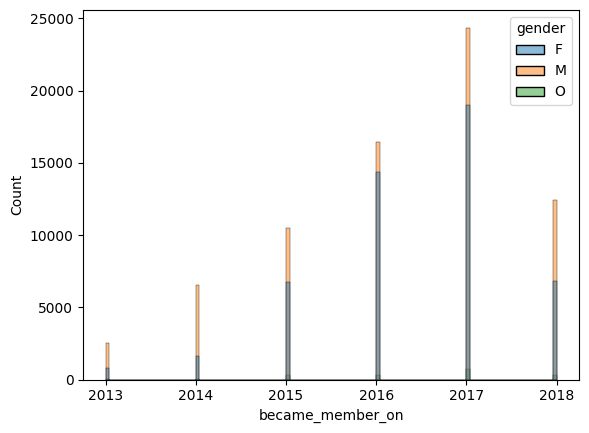

In [141]:
sns.histplot(data=tr, x='became_member_on', hue='gender')